# CNN as baseline


In [1]:
import os,gc,time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.backend import clear_session

RANDOM_SEED = 2023 # random seed for k-fold cross-validation
BATCH_SIZE = 16  
EPOCH_NUM = 100
FOLD_NUM = 5
num_channels = 3 # number of channels = 3: RGB
image_size = (112, 112) # set image size

# early stop metrics monitoring validation loss, in order to compare models, set all epoch=50 fixed, not used now.
#early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#early_stopping_accuracy = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#CALLBACKS = [early_stopping_loss, early_stopping_accuracy]

# set CUDA environment variables
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # use GPU0
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # reduce potential conflict of packages
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true" # GPU memory management

# set data dir
data_dir = "./data/merged_aug_data_224"
#train_dir = "./data/aug_data_224/Train"
#test_dir = "./data/aug_data_224/Test"

# set folder address, avoid duplicated directory name
model_weights_dir = './models/CNN_base'
model_id = 0
while os.path.exists(model_weights_dir):
    model_id += 1
    model_weights_dir = f'./models/CNN_base{model_id}/'
if not os.path.exists(model_weights_dir):
    os.makedirs(model_weights_dir)

# save all configurations in a txt file
with open(os.path.join(model_weights_dir, 'info.txt'), 'w') as file:
    variables = {
        'RANDOM_SEED': RANDOM_SEED,
        'BATCH_SIZE': BATCH_SIZE,
        'EPOCH_NUM': EPOCH_NUM,
        'FOLD_NUM': FOLD_NUM,
        'num_channels': num_channels,
        'image_size': image_size,
        #'monitor of early_stopping_loss':early_stopping_loss.monitor,
        #'patience of early_stopping_loss':early_stopping_loss.patience,
        #'restore_best_weights of early_stopping_loss':early_stopping_loss.restore_best_weights,
        #'monitor of early_stopping_accuracy': early_stopping_loss.monitor,
        #'patience of early_stopping_accuracy': early_stopping_loss.patience,
        #'restore_best_weights of early_stopping_accuracy': early_stopping_loss.restore_best_weights,
        'CUDA_VISIBLE_DEVICES': os.environ["CUDA_VISIBLE_DEVICES"],
        'KMP_DUPLICATE_LIB_OK': os.environ["KMP_DUPLICATE_LIB_OK"],
        'TF_FORCE_GPU_ALLOW_GROWTH': os.environ['TF_FORCE_GPU_ALLOW_GROWTH'],
        'data_dir:' : data_dir
        #'train_dir': train_dir,
        #'test_dir': test_dir
    }
    for variable, value in variables.items():
        file.write(f'{variable} = {value}\n')
print('Model weights have been saved at：', model_weights_dir)

C:\DevTools\Anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Model weights have been saved at： ./models/CNN_base5/


# Design the weak model 2

In [2]:
def create_model():
    model = Sequential()
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_size[0], image_size[1], num_channels)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20))
    
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

# Loading datasets

In [3]:
#Load training set and test set, and their labels
def load_images_and_labels(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        print(f'loading images from {class_dir}')
        for filename in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, filename)
            try:
                image = cv2.imread(image_path)
                #image = tf.cast(image, tf.float16) / 255.0 # normalize, out of memeory
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(class_names.index(class_name))
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {e}")
    return np.array(images), np.array(labels)

In [4]:
# Get training set and test set, and their label
images, labels = load_images_and_labels(data_dir)

loading images from ./data/merged_aug_data_224\Mild


100%|██████████████████████████████████████████████████████████████████████████| 11200/11200 [00:07<00:00, 1453.13it/s]


loading images from ./data/merged_aug_data_224\Moderate


100%|██████████████████████████████████████████████████████████████████████████| 16372/16372 [00:11<00:00, 1427.13it/s]


loading images from ./data/merged_aug_data_224\Non


100%|██████████████████████████████████████████████████████████████████████████| 12800/12800 [00:08<00:00, 1456.23it/s]


# Training the model with 5-fold cross-validation

Use StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=RANDOM_SEED) to split training set into 5 folds.

    

In [5]:
def get_checkpoint_for_fold(model_id):
    '''
    return checkpoint for each fold of cross-validation
    '''
    checkpoint = ModelCheckpoint(model_weights_dir + f'/best_model_{model_id}.h5', 
                                 monitor='val_loss',
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='min',
                                 verbose=2)
    return checkpoint

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,          
    restore_best_weights=True  
)

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
def test_model(model, test_images, test_labels):
    # use data in test set to make predictions
    test_probabilities = model.predict(test_images)
    test_predictions = np.argmax(test_probabilities, axis=1)

    # calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    confusion_mat = confusion_matrix(test_labels, test_predictions)
    weighted_auc_ovr = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovr')
    #print(weighted_auc_ovr)
    weighted_auc_ovo = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovo')
    #print(weighted_auc_ovo)
    print(f'Test set performance:')
    print("Weighted AUC(OvR):", weighted_auc_ovr)
    print("Weighted AUC(OvO):", weighted_auc_ovo)
    print(f'Weighted F1 score = {f1}')
    print(f'Weighted Precision = {precision}, Weighted Recall = {recall}, Accuracy = {accuracy}')
    print('Confusion matrix:\n')
    print(confusion_mat)

    # get the result of classification report
    report = classification_report(test_labels, test_predictions)
    print(f'Result of classification report:\n')
    print(report)
    return f1, weighted_auc_ovr, weighted_auc_ovo

training on fold 0:
Epoch 1/100
1615/1615 [==============================] - 12s 6ms/step - loss: 0.7689 - accuracy: 0.6449 - val_loss: 1.2298 - val_accuracy: 0.3630

Epoch 00001: val_loss improved from inf to 1.22977, saving model to ./models/CNN_base5\best_model_0.h5
Epoch 2/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.5681 - accuracy: 0.7532 - val_loss: 2.1330 - val_accuracy: 0.0889

Epoch 00002: val_loss did not improve from 1.22977
Epoch 3/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.4690 - accuracy: 0.8040 - val_loss: 1.4111 - val_accuracy: 0.3221

Epoch 00003: val_loss did not improve from 1.22977
Epoch 4/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.3978 - accuracy: 0.8357 - val_loss: 1.5948 - val_accuracy: 0.3599

Epoch 00004: val_loss did not improve from 1.22977
Epoch 5/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.3448 - accuracy: 0.8590 - val_loss: 1.2020 - val_accurac

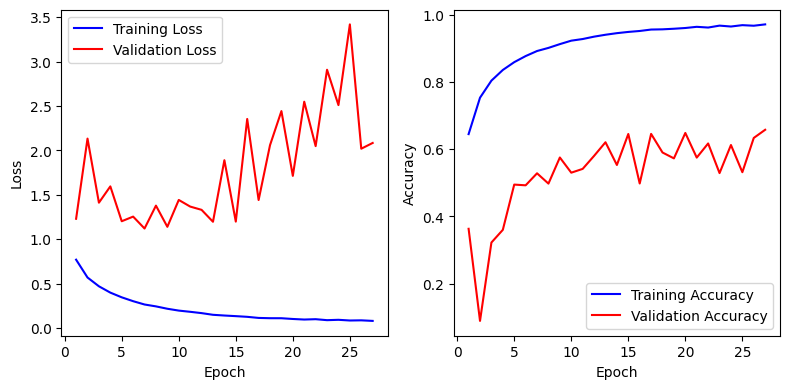

training on fold 1:
Epoch 1/100
1615/1615 [==============================] - 11s 6ms/step - loss: 0.7969 - accuracy: 0.6238 - val_loss: 1.3009 - val_accuracy: 0.2461

Epoch 00001: val_loss improved from inf to 1.30094, saving model to ./models/CNN_base5\best_model_1.h5
Epoch 2/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.6037 - accuracy: 0.7360 - val_loss: 1.2491 - val_accuracy: 0.3037

Epoch 00002: val_loss improved from 1.30094 to 1.24906, saving model to ./models/CNN_base5\best_model_1.h5
Epoch 3/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.4996 - accuracy: 0.7867 - val_loss: 1.7498 - val_accuracy: 0.2974

Epoch 00003: val_loss did not improve from 1.24906
Epoch 4/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.4311 - accuracy: 0.8186 - val_loss: 1.2579 - val_accuracy: 0.4474

Epoch 00004: val_loss did not improve from 1.24906
Epoch 5/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.

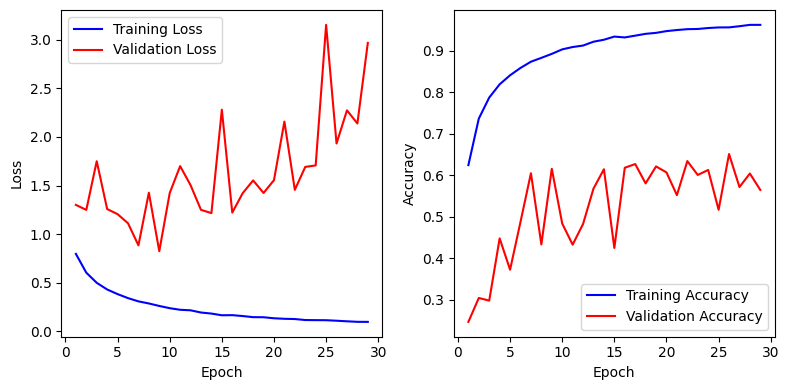

training on fold 2:
Epoch 1/100
1615/1615 [==============================] - 11s 7ms/step - loss: 0.7951 - accuracy: 0.6261 - val_loss: 1.4432 - val_accuracy: 0.3376

Epoch 00001: val_loss improved from inf to 1.44324, saving model to ./models/CNN_base5\best_model_2.h5
Epoch 2/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.6064 - accuracy: 0.7355 - val_loss: 1.5072 - val_accuracy: 0.2464

Epoch 00002: val_loss did not improve from 1.44324
Epoch 3/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.5068 - accuracy: 0.7840 - val_loss: 1.1944 - val_accuracy: 0.4548

Epoch 00003: val_loss improved from 1.44324 to 1.19440, saving model to ./models/CNN_base5\best_model_2.h5
Epoch 4/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.4460 - accuracy: 0.8121 - val_loss: 1.1830 - val_accuracy: 0.4517

Epoch 00004: val_loss improved from 1.19440 to 1.18300, saving model to ./models/CNN_base5\best_model_2.h5
Epoch 5/100
1615/1615 [=

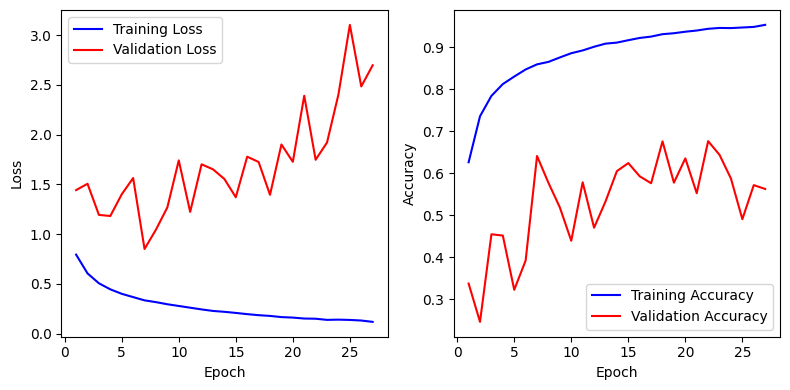

training on fold 3:
Epoch 1/100
1615/1615 [==============================] - 11s 6ms/step - loss: 0.8009 - accuracy: 0.6233 - val_loss: 1.8808 - val_accuracy: 0.1686

Epoch 00001: val_loss improved from inf to 1.88083, saving model to ./models/CNN_base5\best_model_3.h5
Epoch 2/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.6151 - accuracy: 0.7282 - val_loss: 1.3510 - val_accuracy: 0.3153

Epoch 00002: val_loss improved from 1.88083 to 1.35104, saving model to ./models/CNN_base5\best_model_3.h5
Epoch 3/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.5235 - accuracy: 0.7741 - val_loss: 1.4791 - val_accuracy: 0.2768

Epoch 00003: val_loss did not improve from 1.35104
Epoch 4/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.4609 - accuracy: 0.8046 - val_loss: 1.5704 - val_accuracy: 0.2757

Epoch 00004: val_loss did not improve from 1.35104
Epoch 5/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.

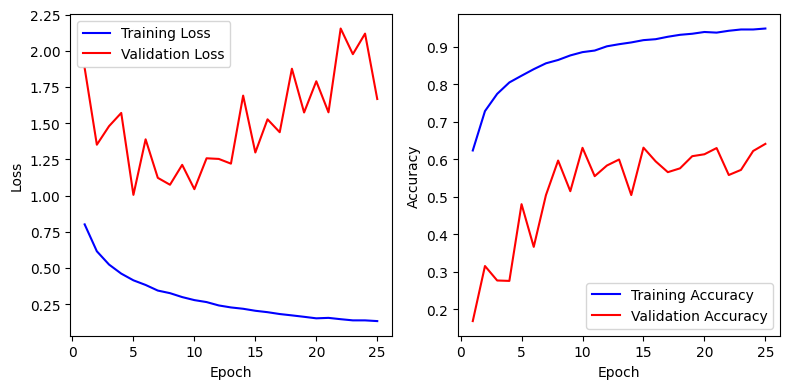

training on fold 4:
Epoch 1/100
1615/1615 [==============================] - 11s 6ms/step - loss: 0.8025 - accuracy: 0.6205 - val_loss: 1.9651 - val_accuracy: 0.0893

Epoch 00001: val_loss improved from inf to 1.96513, saving model to ./models/CNN_base5\best_model_4.h5
Epoch 2/100
1615/1615 [==============================] - 11s 7ms/step - loss: 0.5928 - accuracy: 0.7396 - val_loss: 1.1398 - val_accuracy: 0.4170

Epoch 00002: val_loss improved from 1.96513 to 1.13976, saving model to ./models/CNN_base5\best_model_4.h5
Epoch 3/100
1615/1615 [==============================] - 11s 7ms/step - loss: 0.4888 - accuracy: 0.7906 - val_loss: 1.4245 - val_accuracy: 0.2368

Epoch 00003: val_loss did not improve from 1.13976
Epoch 4/100
1615/1615 [==============================] - 11s 7ms/step - loss: 0.4179 - accuracy: 0.8213 - val_loss: 1.6780 - val_accuracy: 0.2334

Epoch 00004: val_loss did not improve from 1.13976
Epoch 5/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.

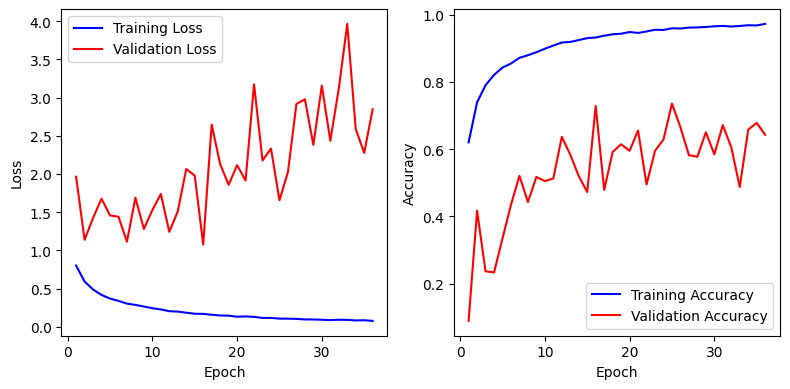

In [7]:
# memory leaking solved by adding gc.collect(), decreasing image size and batch size also helps.
# Following loop works with 32 Gib RAM PC
# set fold with a fixed random seed
kf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=RANDOM_SEED)

#accuracy_list = []
weighted_f1_list = []
auc_ovr_list = []
auc_ovo_list = []
#precision_list = []
#recall_list = []
fold_id = 0

# 5-fold cross-validation
for train_index, test_index in  kf.split(images, labels):
    train_images_fold, test_images_fold = images[train_index], images[test_index]
    train_labels_fold, test_labels_fold = labels[train_index], labels[test_index]
    
    # get model
    model = create_model()

    best_epoch = get_checkpoint_for_fold(fold_id)
    
    # train the model
    print(f'training on fold {fold_id}:')
    history = model.fit(train_images_fold, train_labels_fold, 
                        epochs=EPOCH_NUM, 
                        batch_size=BATCH_SIZE,
                        validation_split=0.2,
                        callbacks=[best_epoch, early_stopping],
                        verbose=1)
    best_model_weight_dir = model_weights_dir + f'/best_model_{fold_id}.h5'

    if os.path.exists(best_model_weight_dir):
        #best_model = create_model(input_shape=(image_size[0], image_size[1], num_channels), num_classes=3)
        best_model = load_model(best_model_weight_dir)
        f1, auc_ovr, auc_ovo = test_model(model, test_images_fold, test_labels_fold)
        
        # store the values of metrics
        weighted_f1_list.append(f1)
        auc_ovr_list.append(auc_ovr)
        auc_ovo_list.append(auc_ovo)

        #move on for next fold
        fold_id += 1

    # get training history
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Get Loss-epoch plot
    num_epochs = len(loss)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss, label='Training Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy changes with epoch plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), accuracy, label='Training Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # releases the memory when there are many models in a loop
    try:
        del model, history, train_images_fold, test_images_fold, train_labels_fold, test_labels_fold
    except Exception as e:
        print(f"fail to release memory")
        print(f"Error message: {e}")
    # finnish a full collection
    gc.collect()
    clear_session()
    

In [8]:
print('Result of 5-fold Cross-validation on Test set data:')
print(f'weighted f1 score :{weighted_f1_list}\n')
print(f'Average of weighted auc OvR in 5 folds: {np.mean(auc_ovr_list)}')
print(f'Variance of weighted auc OvR in 5 folds: {np.var(auc_ovr_list)}')
print(f'Average of weighted auc OvO in 5 folds: {np.mean(auc_ovo_list)}')
print(f'Variance of weighted auc OvO in 5 folds: {np.var(auc_ovo_list)}')
print(f'Average of weighted F1 Score in 5 folds: {np.mean(weighted_f1_list)}')
print(f'Variance of Weighted F1 Score in 5 folds: {np.var(weighted_f1_list)}')

#print(f'Average Precision: { np.mean(precision_list)}')
#print(f'Variance of Precision: {np.var(precision_list)}')

#print(f'Average Recall: {np.mean(recall_list)}')
#print(f'Variance of Recall: {np.var(recall_list)}')

Result of 5-fold Cross-validation on Test set data:
weighted f1 score :[0.7942675947119692, 0.797978146237313, 0.7842044456031758, 0.7340118574564055, 0.8243336253070392]

Average of weighted auc OvR in 5 folds: 0.935492247114172
Variance of weighted auc OvR in 5 folds: 0.0001664465228640668
Average of weighted auc OvO in 5 folds: 0.9278100150227898
Variance of weighted auc OvO in 5 folds: 0.00020703039214092287
Average of weighted F1 Score in 5 folds: 0.7869591338631806
Variance of Weighted F1 Score in 5 folds: 0.0008765374461343742
